This is code only notebook of jax intro. Let's start by reducing error message size as we'll cause them for educational purposes.

In [21]:
%xmode minimal

Exception reporting mode: Minimal


# Getting started with JAX numpy

https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html

In [22]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [23]:
x

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

`block_until_ready` to get result immediately.

In [24]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

The slowest run took 8.00 times longer than the fastest. This could mean that an intermediate result is being cached.
6.33 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


JAX first transformation: `grad`

In [25]:
def sum_of_squares(x):
  return jnp.sum(x**2)

In [26]:
sum_of_sqaures_dx = jax.grad(sum_of_squares)
x = jnp.asarray([1.0, 2.0, 3.0, 4.0])
print(sum_of_squares(x))
print(sum_of_sqaures_dx(x))

30.0
[2. 4. 6. 8.]


In [27]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


Find gradient with respect to a different argument (or several)

In [28]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

## Value and Grad

In [29]:
jax.value_and_grad(sum_squared_error)(x, y)

(Array(0.03999995, dtype=float32),
 Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

## Auxiliary data

Error due to aux data.

In [32]:
def sequared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(sequared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.03999995, dtype=float32), Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

```aux=true``` to return aux data

In [33]:
def sequared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(sequared_error_with_aux, has_aux=True)(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

## Differences from numpy

`jnp.array` can not be modified in-place

In [34]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

array([123,   2,   3])

In [35]:
in_place_modify(jnp.array(x))

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Use `at` and `set` that are side effect free. `x` is not modified.

In [37]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

x = jnp.array([1, 2, 3])
print(jax_in_place_modify(x))
print(x)

"builtin.module"() ({
  "func.func"() ({
  ^bb0(%arg0: tensor<3xsi32>, %arg1: tensor<1xsi32>, %arg2: tensor<si32>):
    %0 = "mps.scatter_nd"(%arg0, %arg2, %arg1) {batch_dims = 0 : ui32, mode = #mps.scatter_mode<set>} : (tensor<3xsi32>, tensor<si32>, tensor<1xsi32>) -> tensor<3xsi32>
    "func.return"(%0) : (tensor<3xsi32>) -> ()
  }) {arg_attrs = [{mhlo.sharding = "{replicated}"}, {mhlo.sharding = "{replicated}"}, {mhlo.sharding = "{replicated}"}], function_type = (tensor<3xsi32>, tensor<1xsi32>, tensor<si32>) -> tensor<3xsi32>, res_attrs = [{}], sym_name = "main", sym_visibility = "public"} : () -> ()
}) {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32, sym_name = "jit_scatter"} : () -> ()


XlaRuntimeError: UNKNOWN: /var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/2546443441.py:2:9: error: 'mps.scatter_nd' op invalid batch dimensions: 0, must be less than ranks of all input tensors
/var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/2546443441.py:2:9: note: see current operation: %0 = "mps.scatter_nd"(%arg0, %arg2, %arg1) {batch_dims = 0 : ui32, mode = #mps.scatter_mode<set>} : (tensor<3xsi32>, tensor<si32>, tensor<1xsi32>) -> tensor<3xsi32>


## Your first JAX training loop

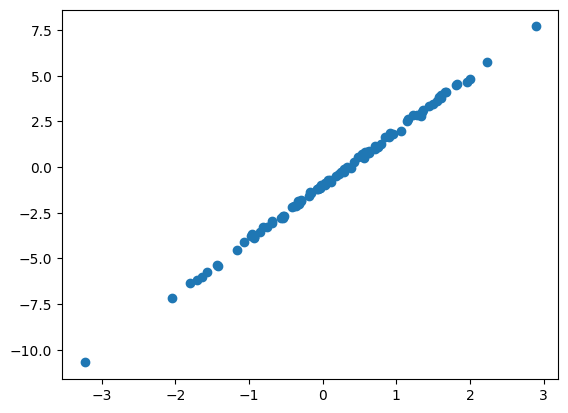

In [40]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise
plt.scatter(xs, ys)

In [41]:
def model(theta, x):
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w=3.00, b=-1.01


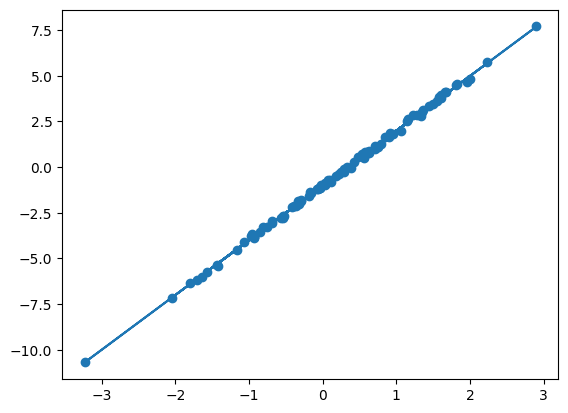

In [42]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
# Correct answer is w=3, b=-1
print(f"{w=:<.2f}, {b=:<.2f}")

# Just In Time Compilation with JAX

https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

## How JAX transforms work

`global_list` update is not in the output. Tracers do not record Python side effect.

In [43]:
import jax
import jax.numpy as jnp

global_list = []
def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


`print` is also a side effect.

In [44]:
def log2_with_print(x):
  print("printed x:", x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.0))

printed x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


jaxpr only knows about the branch we take.

In [45]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


## JIT compiling a function

In [46]:
import jax
import jax.numpy as jnp

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

The slowest run took 19.09 times longer than the fastest. This could mean that an intermediate result is being cached.
7.46 ms ± 9.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
selu_jit = jax.jit(selu)

# Warm up
selu_jit(x).block_until_ready()
%timeit selu_jit(x).block_until_ready()

The slowest run took 20.83 times longer than the fastest. This could mean that an intermediate result is being cached.
4.31 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Why can't we just JIT everything?

Each tracer has a concrete shape (which we're allowed to condition on), but no concrete value.

In [48]:
# Condition on value of x.

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit = jax.jit(f)
f_jit(1)  # should raise an error

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/3042826219.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument x.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [49]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

g_jit = jax.jit(g)
g_jit(10, 20)  # Should raise an error.

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function g at /var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/1062237430.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument n.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

Use [control flow operators](https://jax.readthedocs.io/en/latest/jax.lax.html#control-flow-operators) like `jax.lax.cond` or jit only the part of the function.

In [50]:
@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

Tell jax to a less abstract tracer using `static_argnums` or `static_argnames`. Resulting jaxpr is less flexible.

In [51]:
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(10))

10


In [52]:
def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

30


In [53]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_deocorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

print(g_jit_deocorated(10, 20))

30


## When to use JIT

Jit the largest possible chunk of computation.

In [54]:
print("g jitted:")
%timeit g_jit_correct(10, 20).block_until_ready()

print("g:")
%timeit g(10, 20)

g jitted:
The slowest run took 9.77 times longer than the fastest. This could mean that an intermediate result is being cached.
2.6 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
g:
315 ns ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Caching

Avoid calling `jax.jit` inside loops. Esp., `partial` and `lambda` generate different function hash every time called.

In [55]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
539 ms ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with lambdas:
268 ms ± 63.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with caching:
The slowest run took 22.24 times longer than the fastest. This could mean that an intermediate result is being cached.
108 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Automatic vectorization in JAX
https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html

## Manual vectorization

In [56]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [57]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

print(xs)
print(ws)

[[0 1 2 3 4]
 [0 1 2 3 4]]
[[2. 3. 4.]
 [2. 3. 4.]]


In [58]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

You would normally have to rewrite the function to ensure it is done in vectorized form.

In [59]:
def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1]-1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

## Automatic Vectorization

`jax.vmap` generates an automatic vectorization, tracing functions similarty to `jax.jit` and adding batch axes at the beginning.

In [60]:
def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

auto_batch_convolve = jax.vmap(convolve)
auto_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

If batch dimenstion is not the first, use `in_axes` and `out_axes`.

In [61]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

Array([[11., 11.],
       [20., 20.],
       [29., 29.]], dtype=float32)

Only one of the argument can be batched.

In [62]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
batch_convolve_v3(xs, w)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

## Combining transformation

In [63]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)
jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

# Advanced Automatic Differentiation in JAX

This section is skipped completely since it'd require replicating the entire contents due to amount of contex.

https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html

# Pseudo Random Numbers in JAX

https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html

## Random numbers in numpy

Numpy relies on global `state`.

In [64]:
import numpy as np
np.random.seed(0)

def print_truncated_random_state():
  full_random_state = np.random.get_state()
  print(str(full_random_state)[:460], '...')

print_truncated_random_state()
_ = np.random.uniform()
print_truncated_random_state()

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...
('MT19937', array([2443250962, 1093594115, 1878467924, 2709361018, 1101979660,
       3904844661,  676747479, 2085143622, 1056793272, 3812477442,
       2168787041,  275552121, 2696932952, 3432054210, 1657102335,
       3518946594,  962584079, 1051271004, 3806145045, 1414436097,
       2032348584, 1661738718, 1116708477, 2562755208, 3176189976,
        696824676, 2399811678, 3992505346,  569184356, 2626558620,
        136797809, 4273176064,  296167901, 343 ...


Numpy's sequential equivalent gurantee. Output are the same.

In [65]:
np.random.seed(0)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(0)
print("all at once: ", np.random.uniform(size=3))

individually: [0.5488135  0.71518937 0.60276338]
all at once:  [0.5488135  0.71518937 0.60276338]


## Random numbers in JAX

Below relies on the order of `bar`, `baz` execution and that's enforced by python. JAX can't since it parallelizes.

In [66]:
import numpy as np

np.random.seed(0)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()
def foo(): return bar() + 2 * baz()

print(foo())

1.9791922366721637


JAX random function explicitly consumes the state.

In [67]:
from jax import random
key = random.PRNGKey(42)
print(key)

print(random.normal(key))
print(random.normal(key))

[42 42]
-0.9350606
-0.9350606


`split()` the old key to call a random function. Use `subkey` and then discard it forever.

In [68]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"    \---SPLIT --> new key   ", new_key)
print(r"             \--> new subkey", subkey, "--> normal", normal_sample)
del subkey  # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key  # If we wanted to do this again, we would use new_key as the key.

old key [42 42]
    \---SPLIT --> new key    [1740183447 2549240159]
             \--> new subkey [355035417 137792341] --> normal 0.43600795


To write concisely and to discard old key:

In [69]:
key, subkey = random.split(key)

In [70]:
key, *forty_two_subkeys = random.split(key, num=43)

JAX does not guarantee sequential equivalence.

In [71]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

# Didn't split key since it's not used anymore.
key = random.PRNGKey(42)
print("all at once:", random.normal(key, shape=(3,)))

individually: [-0.5484217  -0.18267898  0.7080024 ]
all at once: [-0.2399927  0.9055816 -1.3873793]


# Working with pytrees

## What is a pytree?

Pytree is just a possibly-nested standard or user-registered Python container.


In [72]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    # This is a single leaf.
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves {leaves}")

[1, 'a', <object object at 0x2d4e34a00>]      has 3 leaves [1, 'a', <object object at 0x2d4e34a00>]
(1, (2, 3), ())                               has 3 leaves [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves [Array([1, 2, 3], dtype=int32)]


## Why pytrees?

- Model paramters
- Dataset entries
- RL agent observations

## Common pytree functions

`jax.tree_map` works analogoulsy with Python's `map`.

In [73]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

Works also with multiple arguments if the stucture exactly matches.

In [74]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

## Example: ML model parameters

`jax.tree_map` returns a new pytree with the same structure but with the value at each leaf mapped. ([Reference](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_map.html))

In [75]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,)))
    )
  return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree_map(lambda x: x.shape, params)


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

Let's train our MLP.

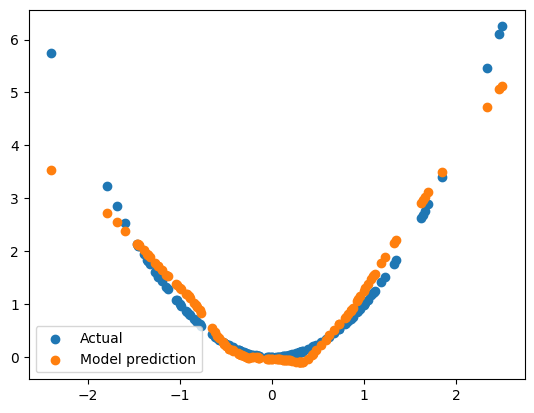

In [76]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      # p from params and g from grads
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys, label="Actual")
plt.scatter(xs, forward(params, xs), label="Model prediction")
plt.legend()

## Key paths

A key path for a leaf is a list of keys, where the length of the list is equal to the depth of the leaf in the pytree

The APIs for working with key paths are:

- `jax.tree_util.tree_flatten_with_path`
- `jax.tree_util.tree_map_with_path`
- `jax.tree_util.keystr`

*Colab fails here since it doesn't support Jax 0.4.*

In [77]:
import jax
import collections

ATuple = collections.namedtuple("ATuple", ("name"))

tree = [1, {"k1": 2, "k2": (3, 4)}, ATuple("foo")]
# NOTE: This fails when
flattened, pytree_def = jax.tree_util.tree_flatten_with_path(tree)
print("Pytree def:", pytree_def, '\n')
for key_path, value in flattened:
  print(key_path)
  print(f"Value of tree{jax.tree_util.keystr(key_path)}: {value}")
  print('--------')

Pytree def: PyTreeDef([*, {'k1': *, 'k2': (*, *)}, CustomNode(namedtuple[ATuple], [*])]) 

(SequenceKey(idx=0),)
Value of tree[0]: 1
--------
(SequenceKey(idx=1), DictKey(key='k1'))
Value of tree[1]['k1']: 2
--------
(SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0))
Value of tree[1]['k2'][0]: 3
--------
(SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1))
Value of tree[1]['k2'][1]: 4
--------
(SequenceKey(idx=2), GetAttrKey(name='name'))
Value of tree[2].name: foo
--------


## Custom pytree node

Your own container is considered as leaf.

In [78]:
import jax

class MyContainer:

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

jax.tree_util.tree_leaves([
    MyContainer("Alice", 1, 2, 3),
    MyContainer("Bob", 4, 5, 6),
])

[<__main__.MyContainer at 0x2b7fdeb10>, <__main__.MyContainer at 0x16a3e8e50>]

We can't go over elements inside the container.

In [79]:
try:
  jax.tree_map(lambda x: x + 1, [
    MyContainer("Alice", 1, 2, 3),
    MyContainer("Bob", 4, 5, 6),
  ])
except TypeError as e:
  print("TypeEror:", e)

TypeEror: unsupported operand type(s) for +: 'MyContainer' and 'int'


Use `register_pytree_node` to tell JAX how to flatten our container.

In [80]:
from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as child, so it is a aux data.
  # aux data is usually a description fo the structure of a node
  # e.g,. the keys of a dict - anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
    return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer
)

In [81]:
my_tree = [
    MyContainer("Alice", 1, 2, 3),
    MyContainer("Bob", 4, 5, 6),
]

print(jax.tree_util.tree_leaves(my_tree))

[1, 2, 3, 4, 5, 6]


Or use key path API of `register_pytree_with_keys`.

In [82]:
class MyKeyPathContainer(MyContainer):
  pass

def flatten_with_keys_MyKeyPathContainer(container) -> tuple[Iterable[int], str]:
  # GetAttrKey is a common way to express an attribute key. Users are free
  # to pick any other expression that fits their use cases the best.
  flat_contents = [
      (jax.tree_util.GetAttrKey("a"), container.a),
      (jax.tree_util.GetAttrKey("b"), container.b),
      (jax.tree_util.GetAttrKey("c"), container.c),
  ]
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyKeyPathContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyKeyPathContainer:
    return MyKeyPathContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_with_keys(
    MyKeyPathContainer, flatten_with_keys_MyKeyPathContainer,
    unflatten_MyKeyPathContainer)

In [83]:
tree = [
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6)
]

print(jax.tree_util.tree_leaves(tree))

[1, 2, 3, 4, 5, 6]


For containers registered with `register_pytree_node`, keys are flat index.

In [84]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyContainer container{jax.tree_util.keystr(key_path)}: {value}')

flattened, _ = jax.tree_util.tree_flatten_with_path(MyKeyPathContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyKeyPathContainer container{jax.tree_util.keystr(key_path)}: {value}')

MyContainer container[<flat index 0>]: 1
MyContainer container[<flat index 1>]: 2
MyContainer container[<flat index 2>]: 3
MyKeyPathContainer container.a: 1
MyKeyPathContainer container.b: 2
MyKeyPathContainer container.c: 3


Some python containers work out-of-the-box.

In [85]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# `tuple` is already registered with JAX and NamedTuple is its subclass.
jax.tree_util.tree_leaves([
    MyOtherContainer("Alice", 1, 2, 3),
    MyOtherContainer("Bob", 1, 2, 3)
])

['Alice', 1, 2, 3, 'Bob', 1, 2, 3]

## Common pytree gotchas and patterns

### Gotchas

`tree_map` goes over the leaves of shape which is [2, 3, 3, 4].

In [86]:
import jax
import jax.numpy as jnp

a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

shapes = jax.tree_map(lambda x: x.shape, a_tree)
print(shapes)
# It doesn't return (2, 3), (3, 4) arrays.
print(jax.tree_map(jnp.ones, shapes))

[(2, 3), (3, 4)]
[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


`shapes`'s leaves are not the tuples.

In [87]:
jax.tree_util.tree_leaves(shapes)

[2, 3, 3, 4]

One way is to not using the intermediate treemap.

In [88]:
jax.tree_map(lambda x: jnp.ones(x.shape), a_tree)

[Array([[1., 1., 1.],
        [1., 1., 1.]], dtype=float32),
 Array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)]

Alternatively, turn shapes into `np.array` or `jnp.array` which is considered as leaf.

In [89]:
shapes = jax.tree_map(lambda x: jnp.array(x.shape), a_tree)
print(jax.tree_util.tree_leaves(shapes))
print(jax.tree_map(jnp.ones, shapes))

[Array([2, 3], dtype=int32), Array([3, 4], dtype=int32)]
[Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


### Handling of None

`None` is a node without children.

In [90]:
jax.tree_util.tree_leaves([None, None, None])

[]

## Patterns

### Transposing trees

Use `tree_map`

In [92]:
def tree_transpose(list_of_trees):
    return jax.tree_map(lambda *xs: list(xs), *list_of_trees)

episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

Or `jax.tree_transpose`

In [93]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

/var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/112383129.py:2: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
/var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/112383129.py:3: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  inner_treedef = jax.tree_structure(episode_steps[0]),
/var/folders/09/9zmlsg756kxfcbx6l3tdhf600000gn/T/ipykernel_68760/112383129.py:1: FutureWarning: jax.tree_transpose is deprecated, and will be removed in a future release. Use jax.tree_util.tree_transpose instead.
  jax.tree_transpose(


{'obs': [3, 4], 't': [1, 2]}

# Parallel evaluation in JAX
https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html

Vectorization via `jax.vmap` and device parallelism via `jax.pmap`.

## The basics

In [4]:
import jax
import numpy as np
import jax.numpy as jnp

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(x, w):
    output = []
    for i in range(1, len(x) - 1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [5]:
n_devices = jax.local_device_count()
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

If you have multiple devices, there should be multiple rows.

In [6]:
print(xs)
print(ws)

[[0 1 2 3 4]]
[[2. 3. 4.]]


Vectorize using `jax.vmap`

In [7]:
jax.vmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

Spread out computation across devices using `jax.pmap`

In [8]:
jax.pmap(convolve)(xs, ws)

Array([[11., 20., 29.]], dtype=float32)

What's returned are `jax.Array` sharded across devices. They stay there avoiding cross device communications when there's another parallel computation.

In [9]:
jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))

Array([[ 78., 138., 198.]], dtype=float32)

## Specifying `in_axes`

`in_axes`:
- None: Braodcast the argument
- 0: Split by leading axis

In [10]:
# No need for replicating w to get ws.
jax.pmap(convolve, in_axes=(0, None))(xs, w)

Array([[11., 20., 29.]], dtype=float32)

## `pmap` and `jit`

`pmap` jit compiles already while we had to `jax.jit(jax.vmap...)` before.

## Communication between devices

Specify `pmap`-ed axis through `axis_name` to use [collective ops](https://jax.readthedocs.io/en/latest/jax.lax.html#parallel-operators) for passing data between devices. 

In [12]:
def normalized_convolution(x, w):
    output = []
    for i in range(1, len(x) - 1):
        output.append(jnp.dot(x[i-1:i+2], w))
    output = jnp.array(output)
    return output / jax.lax.psum(output, axis_name='p')

# axis_name can be anything you and jax.lax.psum uses it
# to know which axis to communicate across.
jax.pmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[1., 1., 1.]], dtype=float32)

`jax.vmap` also supports `axis_name` to use `jax.lax.p*` in the vectorization.

In [13]:
jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

Array([[1., 1., 1.]], dtype=float32)

## Nesting `jax.pmap` and `jax.vmap`

We use string as axis_name for collective operation when nesting:

jax.vmap(jax.pmap(f, axis_name='i'), axis_name='j')

## Example

In [20]:
import jax
import jax.numpy as jnp

from typing import NamedTuple
import functools

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray
    
def init(rng) -> Params:
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)

def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
    pred = params.weight * xs + params.bias
    return jnp.mean((pred - ys)**2)

LEARNING_RATE = 0.005

@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, 
           xs: jnp.ndarray, 
           ys: jnp.ndarray) -> tuple[Params, jnp.ndarray]:
    loss, grad = jax.value_and_grad(loss_fn)(params, xs, ys)
    # Combine grads and loss across devices.
    grads = jax.lax.pmean(grad, axis_name='num_devices')
    loss = jax.lax.pmean(loss, axis_name='num_devices')
    new_params = jax.tree_map(
        lambda p, g: p - g * LEARNING_RATE, params, grads)
    return new_params, loss

true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

params = init(jax.random.PRNGKey(123))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(
    lambda x: jnp.array([x] * n_devices), params)

# jax.Array that stays on the device
print(type(replicated_params.weight))

def split(arr):
    return arr.reshape(
        n_devices, arr.shape[0] // n_devices, *arr.shape[1:])
    
x_split = split(xs)
y_split = split(ys)

# Vanilla np array stays on the CPU then sent to device on every
# update call.
print(type(x_split))

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'numpy.ndarray'>


In [34]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a `{type(obj)}`")
    
for i in range(1000):
    replicated_params, loss = update(
        # These are all (n_devices, ...) shape.
        replicated_params, x_split, y_split)
    if i == 0:
        # These two are jax.Arrays staying on the devies.
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        # Remains as np on the host.
        type_after_update('x_split', x_split)
    if i % 100 == 0:
        # Every device has the identical loss. We pick 0th.
        print(f"Step {i:3d}, loss: {loss[0]:.3f}, "
              f"weight: {replicated_params.weight[0]:.3f}, "
              f"bias: {replicated_params.bias[0]:.3f}")
    
# Get the param from the first deivce    
print(replicated_params)
params = jax.device_get(
    jax.tree_map(lambda x: x[0], replicated_params))        

after first `update()`, `replicated_params.weight` is a `<class 'jaxlib.xla_extension.ArrayImpl'>`
after first `update()`, `loss` is a `<class 'jaxlib.xla_extension.ArrayImpl'>`
after first `update()`, `x_split` is a `<class 'numpy.ndarray'>`
Step   0, loss: 0.225, weight: 2.043, bias: -0.967
Step 100, loss: 0.225, weight: 2.043, bias: -0.967
Step 200, loss: 0.225, weight: 2.043, bias: -0.967
Step 300, loss: 0.225, weight: 2.043, bias: -0.967
Step 400, loss: 0.225, weight: 2.043, bias: -0.967
Step 500, loss: 0.225, weight: 2.043, bias: -0.967
Step 600, loss: 0.225, weight: 2.043, bias: -0.967
Step 700, loss: 0.225, weight: 2.043, bias: -0.967
Step 800, loss: 0.225, weight: 2.043, bias: -0.967
Step 900, loss: 0.225, weight: 2.043, bias: -0.967
Params(weight=Array([2.043408], dtype=float32), bias=Array([-0.966768], dtype=float32))


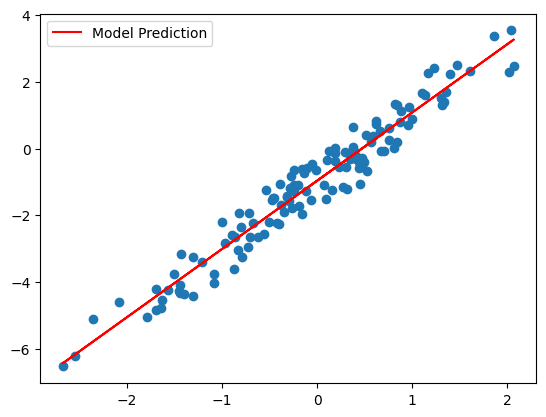

In [35]:
import matplotlib.pyplot as plt

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, 
         c='red', label='Model Prediction')
plt.legend()
plt.show()

# Stateful Computations in JAX